In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
! pip install geopandas

In [3]:
#importing csv data to pandas dataframes
df_reviews = pd.read_csv('reviews.csv')
df_listings = pd.read_csv('listings.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (43,61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,4826,3419,2009-06-01,13823,Anja,We just came back from a weeks stay at Kaan's ...
1,20815,31174,2010-03-24,49388,Chuck,My daughter and her friend and I all stayed at...
2,20815,40738,2010-05-08,93598,Sara,You cannot find a better place to stay in Turk...
3,20815,49182,2010-06-02,108540,Suzan,This comfortable apartment truly deserves the ...
4,20815,85462,2010-08-27,126482,William,I second all the excellent reviews of this pla...


In [5]:
df_listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,4826,https://www.airbnb.com/rooms/4826,20200428053711,2020-04-29,The Place,My place is close to great views. My place is ...,A double bed apartment on the Asian side of Is...,My place is close to great views. My place is ...,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/15347/ba87...,NaN,6603,https://www.airbnb.com/users/show/6603,Kaan,2009-01-14,"Istanbul, Istanbul, Turkey","Hello...\r\nI am Kaan and I am from Istanbul, ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/6603/profile_...,https://a0.muscache.com/im/users/6603/profile_...,Üsküdar,1.0,1.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Istanbul Province, Istanbul, Turkey",Üsküdar,Uskudar,...,$182.00,1,730,1,1,730,730,1.0,730.0,36 months ago,t,30,60,90,365,2020-04-29,1,0,2009-06-01,2009-06-01,100.0,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,f,flexible,f,f,1,1,0,0,0.01
1,20815,https://www.airbnb.com/rooms/20815,20200428053711,2020-04-29,The Bosphorus from The Comfy Hill,Watch The Bosphorus from The Comfy Hill. A spa...,"The low green hills of Arnavutköy, the lovely,...",Watch The Bosphorus from The Comfy Hill. A spa...,none,"The lovely neighborhood, Arnavutkoy, is locate...",The house may be suited with extra inflatable ...,"The city center, Taksim is about 6-7 kilometer...",Our dear guests may enjoy the oven and the was...,"Depending on our time available, we may even t...",- Windows facing the street should not be left...,NaN,NaN,https://a0.muscache.com/im/pictures/94805791/4...,NaN,78838,https://www.airbnb.com/users/show/78838,Gülder,2010-02-08,"Ankara, Ankara, Turkey",Başar Family\r\n\r\nGülder (mother): Owner of ...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/78838/profile...,https://a0.muscache.com/im/users/78838/profile...,Beşiktaş,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'wor...",t,f,"Istanbul, Turkey",Beşiktaş,Besiktas,...,$245.00,365,900,365,365,900,900,365.0,900.0,5 months ago,t,12,23,36,241,2020-04-29,41,0,2010-03-24,2018-11-07,90.0,9.0,9.0,10.0,10.0,10.0,9.0,f,NaN,NaN,f,f,moderate,t,f,2,1,1,0,0.33


In [6]:
def clean_zipcode(input_series):

  output_list = [map_func_zipcode(item) for item in input_series]
  
  return pd.Series(output_list, index=input_series.index)


def map_func_zipcode(x):

  try:
    y = int(x)

    if y < 34000 or y > 35000:
      return str(0)

    return str(y)

  except:
    return str(0)


def clean_price(input_series):

  input_series = input_series.str.replace(',', '')
  input_series = input_series.str.replace('$', '')
  input_series = input_series.astype('float')

  return input_series

In [7]:
def clean_features(pd_series):

  if pd_series.name == 'zipcode':
    return clean_zipcode(pd_series)

  elif pd_series.name == 'price':
    return clean_price(pd_series)

  else:
    return pd_series 

In [8]:
df_listings = df_listings.apply(clean_features, axis=0)

In [9]:
df_listings = df_listings[df_listings['is_location_exact'] == 't']

In [10]:
df_reviews = df_reviews.drop(columns=['id', 'reviewer_id', 'reviewer_name'])

In [11]:
df_locations = df_listings[['id', 'neighbourhood_cleansed', 'zipcode', 'price']]

In [12]:
df_merged = df_locations.merge(df_reviews, left_on='id', right_on='listing_id', how='right')
df_merged = df_merged.drop(columns=['listing_id'])

In [13]:
df_merged.head()

,id,neighbourhood_cleansed,zipcode,price,date,comments
0,20815.0,Besiktas,34345,832.0,2010-03-24,My daughter and her friend and I all stayed at...
1,20815.0,Besiktas,34345,832.0,2010-05-08,You cannot find a better place to stay in Turk...
2,20815.0,Besiktas,34345,832.0,2010-06-02,This comfortable apartment truly deserves the ...
3,20815.0,Besiktas,34345,832.0,2010-08-27,I second all the excellent reviews of this pla...
4,20815.0,Besiktas,34345,832.0,2010-09-03,Thanks to Firat and especially Arda for their ...


In [14]:
df_merged.dtypes

id                        float64
neighbourhood_cleansed     object
zipcode                    object
price                     float64
date                       object
comments                   object
dtype: object

In [15]:
df_merged['date'] = pd.to_datetime(df_merged['date'], format='%Y/%m/%d')

In [16]:
df_merged.dtypes

id                               float64
neighbourhood_cleansed            object
zipcode                           object
price                            float64
date                      datetime64[ns]
comments                          object
dtype: object

In [17]:
df_vis = df_merged.groupby('neighbourhood_cleansed').resample('M', on='date').count()

In [18]:
df_vis.head(10)

id  neighbourhood_cleansed  ...  date  comments
neighbourhood_cleansed date                                    ...                
Adalar                 2015-08-31   1                       1  ...     1         1
                       2015-09-30   2                       2  ...     2         2
                       2015-10-31   0                       0  ...     0         0
                       2015-11-30   1                       1  ...     1         1
                       2015-12-31   0                       0  ...     0         0
                       2016-01-31   1                       1  ...     1         1
                       2016-02-29   0                       0  ...     0         0
                       2016-03-31   2                       2  ...     2         2
                       2016-04-30   4                       4  ...     4         4
                       2016-05-31   0                       0  ...     0         0

[10 rows x 6 columns]

In [19]:
df_vis = df_vis.drop(columns=['date','neighbourhood_cleansed']).reset_index()

In [20]:
top_neighbourhood_list = df_merged.groupby('neighbourhood_cleansed').count().sort_values(by='comments', ascending=False)['comments'].index.to_list()[:7]

In [21]:
top_neighbourhood_list

['Beyoglu', 'Fatih', 'Sisli', 'Kadikoy', 'Besiktas', 'Adalar', 'Uskudar']

In [22]:
df_vis = df_vis[df_vis['neighbourhood_cleansed'].isin(top_neighbourhood_list)]

In [23]:
df_vis

,neighbourhood_cleansed,date,id,zipcode,price,comments
0,Adalar,2015-08-31,1,1,1,1
1,Adalar,2015-09-30,2,2,2,2
2,Adalar,2015-10-31,0,0,0,0
3,Adalar,2015-11-30,1,1,1,1
4,Adalar,2015-12-31,0,0,0,0
...,...,...,...,...,...,...
1758,Uskudar,2019-11-30,25,25,25,25
1759,Uskudar,2019-12-31,37,37,37,37
1760,Uskudar,2020-01-31,40,40,40,40
1761,Uskudar,2020-02-29,31,31,31,31


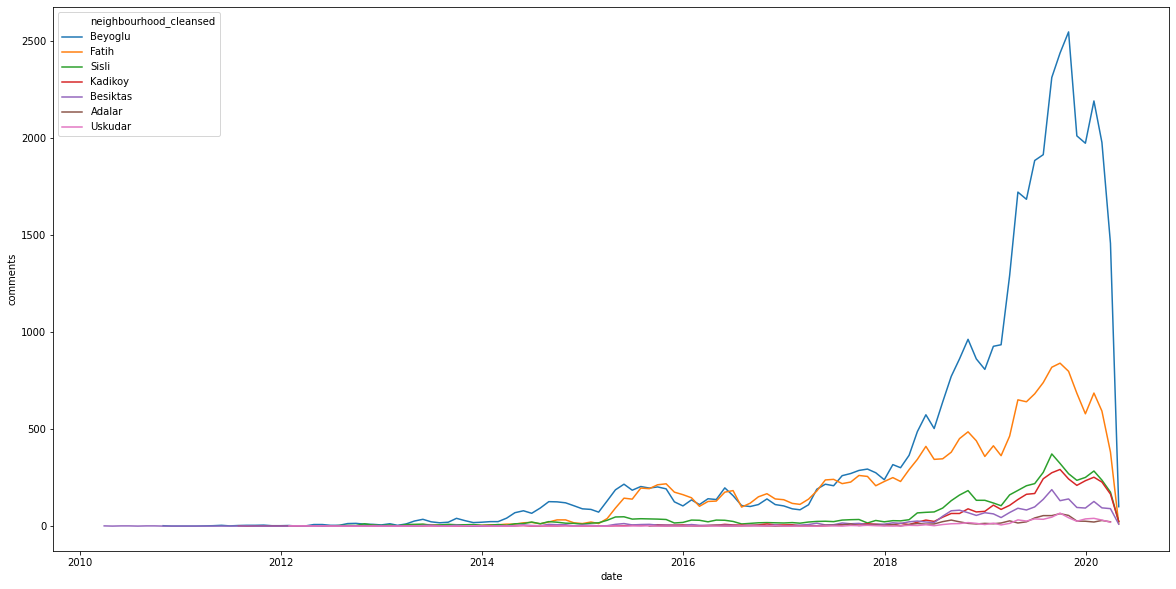

In [24]:
plt.figure(figsize=(20,10))
sns.lineplot(data=df_vis, x ='date' ,y='comments', hue='neighbourhood_cleansed', hue_order=top_neighbourhood_list)
             
plt.show()


## Comparing price for different neighbourhoods in time

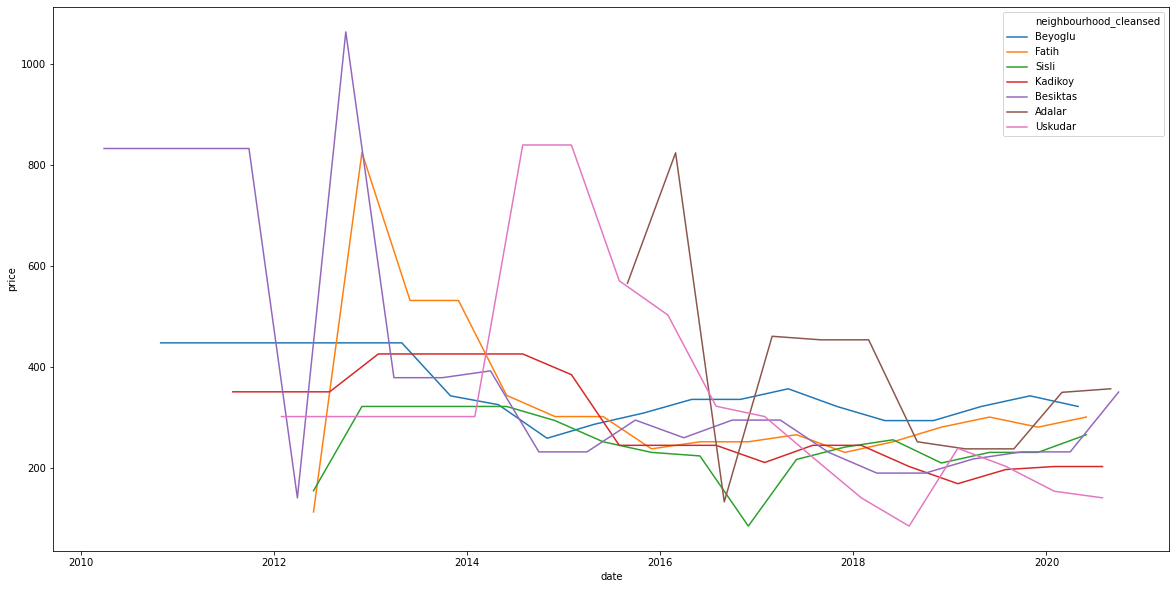

In [25]:
df_vis_price = df_merged.groupby('neighbourhood_cleansed').resample('6M', on='date').median()

df_vis_price = df_vis_price.reset_index()

#df_vis_price['neighbourhood_zipcode'] = df_vis_price['zipcode'].map(zip_neighbourhood_dict)


df_vis_price = df_vis_price[df_vis_price['neighbourhood_cleansed'].isin(top_neighbourhood_list)]



plt.figure(figsize=(20,10))
sns.lineplot(data=df_vis_price, x ='date' ,y='price', hue='neighbourhood_cleansed', hue_order=top_neighbourhood_list)
             
plt.show()

Median prices for each neighbourhood

In [26]:
df_locations

,id,neighbourhood_cleansed,zipcode,price
1,20815,Besiktas,34345,832.0
3,28277,Sisli,34373,747.0
12,41753,Beyoglu,34433,447.0
15,47377,Beyoglu,34437,350.0
17,49955,Fatih,34330,377.0
...,...,...,...,...
23432,43301272,Beyoglu,34435,168.0
23433,43301677,Beyoglu,34435,168.0
23434,43301830,Beyoglu,34435,168.0
23435,43301882,Beyoglu,34435,168.0


In [27]:
df_vis = df_locations.groupby('neighbourhood_cleansed').median()

In [28]:
df_vis = df_vis.reset_index()

In [29]:
df_vis.head()

,neighbourhood_cleansed,id,price
0,Adalar,29225072.5,453.0
1,Arnavutkoy,40880619.5,202.0
2,Atasehir,35964057.5,202.0
3,Avcilar,35953621.0,146.0
4,Bagcilar,41025610.0,314.0


In [30]:
df_prices = df_vis.sort_values(by='price', ascending=False)

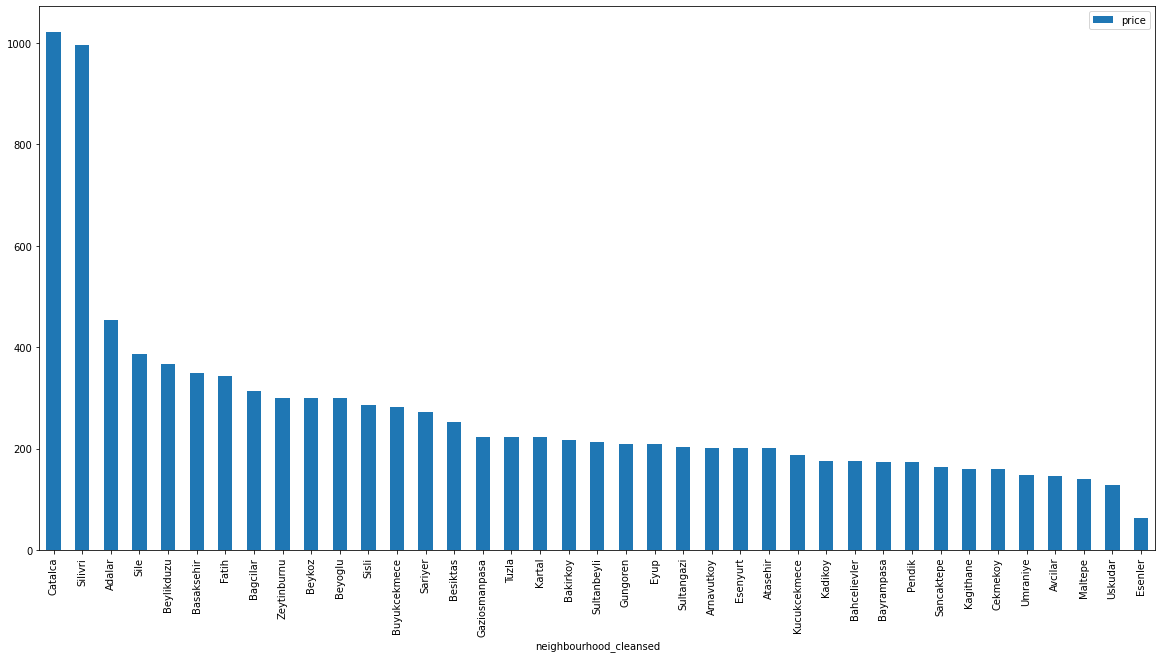

In [31]:
df_prices.plot.bar(x='neighbourhood_cleansed', y='price', rot=90, figsize=(20,10))

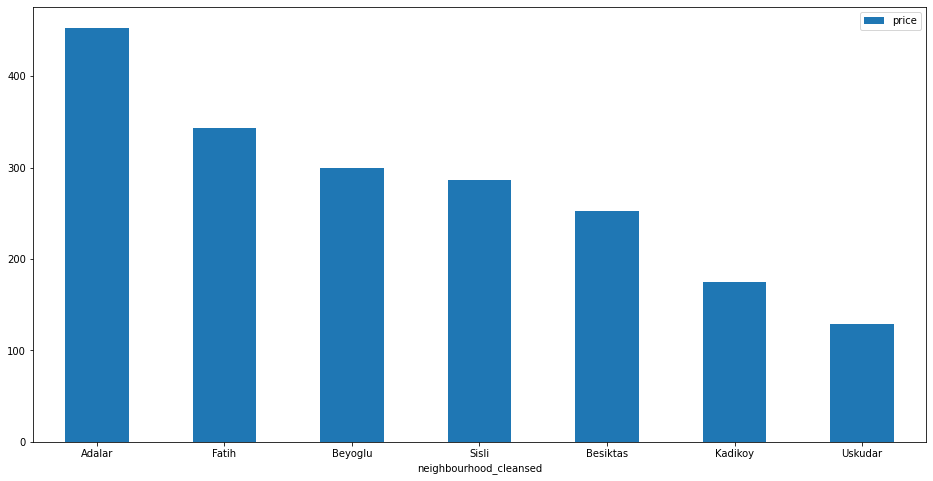

In [32]:
df_prices_top_neighbourhoods = df_prices[df_prices['neighbourhood_cleansed'].isin(top_neighbourhood_list)]
df_prices_top_neighbourhoods.plot.bar(x='neighbourhood_cleansed', y='price', rot=0, figsize=(16,8));

# Comparing Small neighbourhoods by number of comments

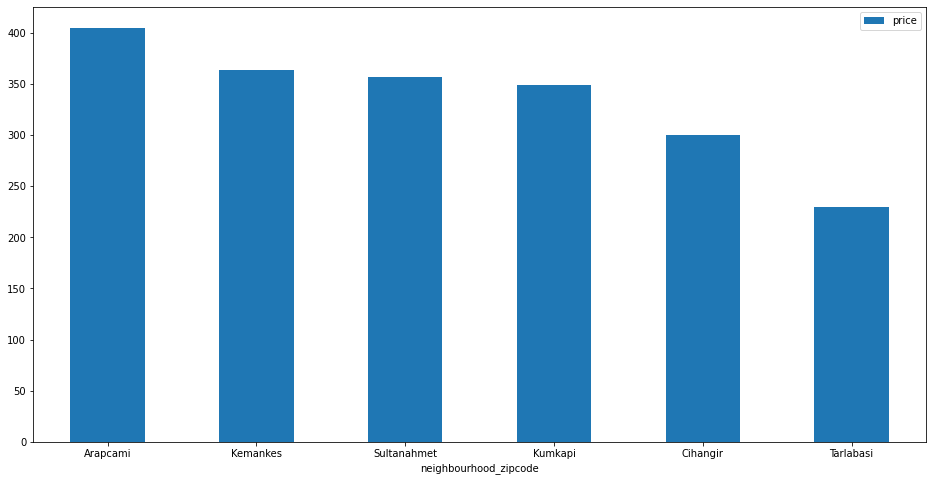

In [111]:
df_vis_zip = df_locations.groupby('zipcode').median()


df_vis_zip = df_vis_zip.reset_index()


top_neighbourhood_list = df_merged.groupby('zipcode').count().sort_values(by='comments', ascending=False)['comments'].index.to_list()[:6]



df_vis_zip = df_vis_zip[df_vis_zip['zipcode'].isin(top_neighbourhood_list)]



zip_neighbourhood_dict = {'34435': 'Tarlabasi', '34122': 'Sultanahmet', '34433': 'Cihangir', 
                          '34421': 'Arapcami', '34425':'Kemankes', '34130':'Kumkapi'}


top_neighbourhood_names = list(zip_neighbourhood_dict.values())


df_vis_zip['neighbourhood_zipcode'] = df_vis_zip['zipcode'].map(zip_neighbourhood_dict)



df_vis_zip.sort_values(by='price', ascending=False).plot.bar(x='neighbourhood_zipcode', y='price', rot=0, figsize=(16,8));

# Comparing popularity of small neighbourhoods in time

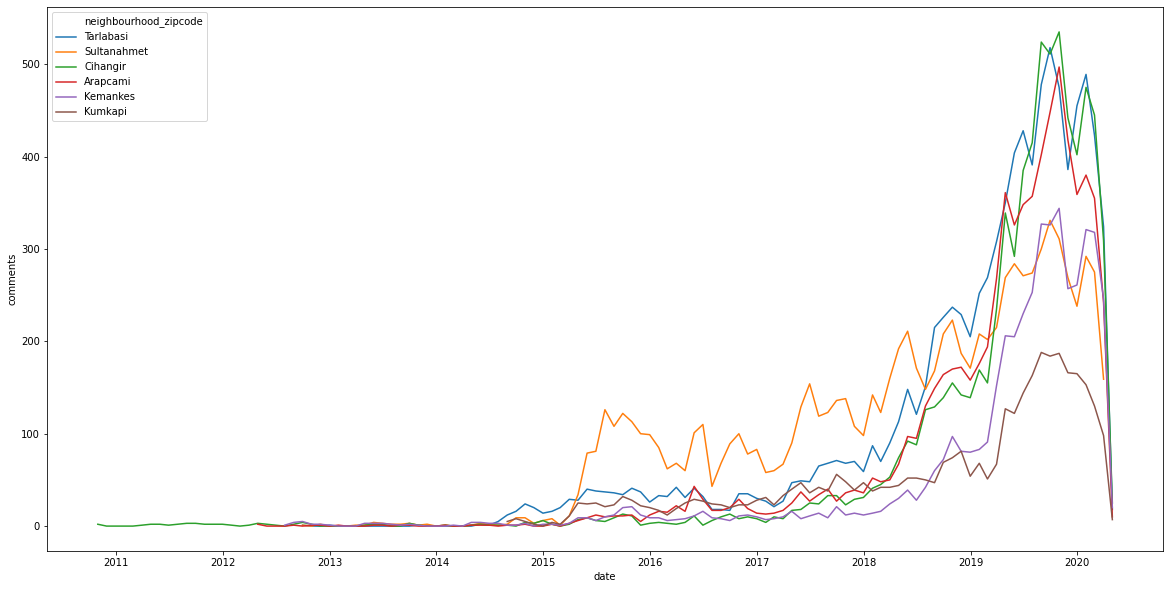

In [112]:
df_vis_zip = df_merged.groupby('zipcode').resample('M', on='date').count()

df_vis_zip = df_vis_zip.drop(columns=['date','zipcode']).reset_index()

df_vis_zip['neighbourhood_zipcode'] = df_vis_zip['zipcode'].map(zip_neighbourhood_dict)


df_vis_zip = df_vis_zip[df_vis_zip['neighbourhood_zipcode'].isin(top_neighbourhood_names)]



plt.figure(figsize=(20,10))
sns.lineplot(data=df_vis_zip, x ='date' ,y='comments', hue='neighbourhood_zipcode', hue_order=top_neighbourhood_names)
             
plt.show()


## Comparing price for different neighbourhoods in time

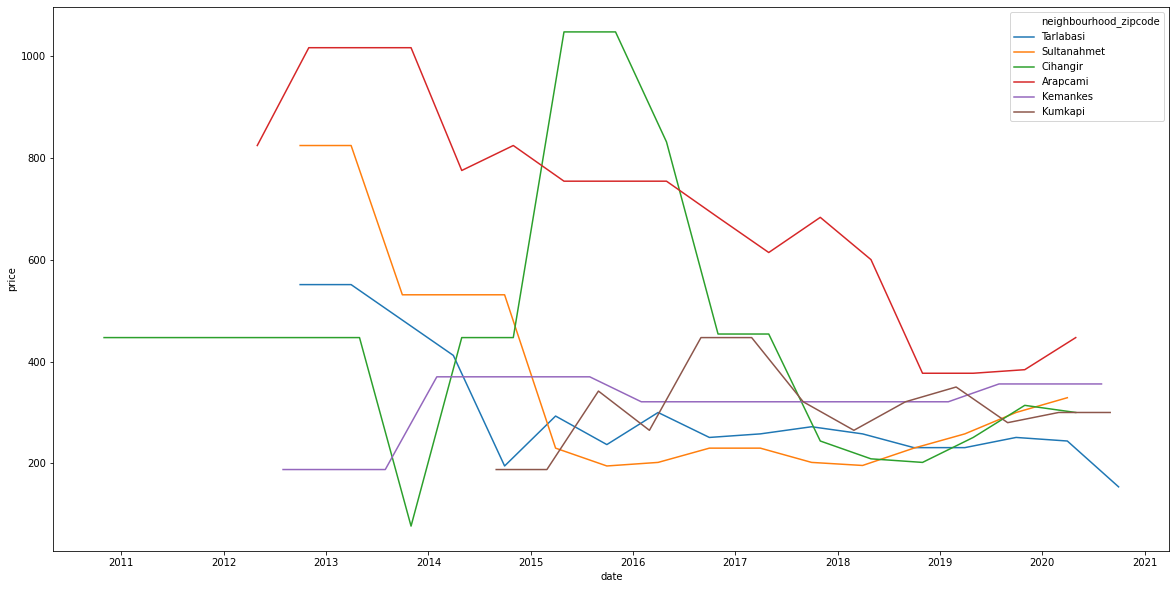

In [113]:
df_vis_price = df_merged.groupby('zipcode').resample('6M', on='date').median()

df_vis_price = df_vis_price.reset_index()

df_vis_price['neighbourhood_zipcode'] = df_vis_price['zipcode'].map(zip_neighbourhood_dict)


df_vis_price = df_vis_price[df_vis_price['neighbourhood_zipcode'].isin(top_neighbourhood_names)]



plt.figure(figsize=(20,10))
sns.lineplot(data=df_vis_price, x ='date' ,y='price', hue='neighbourhood_zipcode', hue_order=top_neighbourhood_names)
             
plt.show()

Geolocation Visualization

In [114]:
import folium
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

In [121]:
#df_locations['neighbourhood_cleansed'].value_counts().reset_index()
df_merged['neighbourhood_cleansed'].value_counts().reset_index()

,index,neighbourhood_cleansed
0,Beyoglu,42180
1,Fatih,19657
2,Sisli,5783
3,Kadikoy,3665
4,Besiktas,2379
5,Adalar,722
6,Uskudar,610
7,Atasehir,518
8,Maltepe,455
9,Sariyer,319


In [122]:
#df_neighbourhood_counts = df_locations['neighbourhood_cleansed'].value_counts().reset_index()
df_neighbourhood_counts = df_merged['neighbourhood_cleansed'].value_counts().reset_index()


In [123]:
gpd_neighbourhoods = gpd.read_file('neighbourhoods.geojson')

In [124]:
gpd_neighbourhoods.head()

,neighbourhood,neighbourhood_group,geometry
0,Sile,None,"MULTIPOLYGON (((29.40004 41.08274, 29.40101 41..."
1,Catalca,None,"MULTIPOLYGON (((28.53614 41.10624, 28.53185 41..."
2,Eyup,None,"MULTIPOLYGON (((28.94881 41.26322, 28.94760 41..."
3,Sariyer,None,"MULTIPOLYGON (((29.05429 41.08144, 29.05436 41..."
4,Arnavutkoy,None,"MULTIPOLYGON (((28.81849 41.13628, 28.80986 41..."


In [133]:
gpd_neighbourhoods = pd.merge(gpd_neighbourhoods, df_neighbourhood_counts, left_on='neighbourhood', right_on='index')

In [134]:
#gpd_neighbourhoods['neighbourhood_cleansed'] = np.log(gpd_neighbourhoods['neighbourhood_cleansed'])

In [135]:
istanbul = [41.0082, 28.9784]

# Create map
m = folium.Map(location=istanbul, tiles='CartoDB positron', zoom_start=11, width='80%', height='80%')



# Build choropleth
m.choropleth(
    geo_data=gpd_neighbourhoods,
    name='geometry',
    data=gpd_neighbourhoods,
    columns=['neighbourhood', 'neighbourhood_cleansed'],
    key_on='feature.properties.neighbourhood',
    fill_color='Reds',
    fill_opacity=0.5,
    line_opacity=1.0,
    legend_name='Number of comments for each neighbourhood'
)


# Create LayerControl and add it to the map            
folium.LayerControl().add_to(m)

# Display the map
display(m)  

Word Clouds

In [44]:
! pip install googletrans

In [45]:
from googletrans import Translator

In [46]:
def comment_splitter(input_string):

  len_string = len(input_string)
  string_list = []
  maximum_len = 14999

  s = 0

  if len_string > maximum_len:

    for i in range(maximum_len, len_string, maximum_len):

      string_list.append(input_string[s:i])

      s = i

  else:
    string_list.append(input_string)


  try:
    string_list.remove('')

  except:
    return string_list

  return string_list

In [47]:
def comment_list_translator(comment_list):

  translated_string = str()
  

  for string in comment_list:

    translator = Translator()
    translated_string += translator.translate(string).text

  return translated_string

In [48]:
df_merged['comments'] = df_merged['comments'].astype(str)

In [49]:
df_grouped_strings = df_merged.groupby(['neighbourhood_cleansed'])['comments'].apply('.'.join).reset_index()

In [50]:
df_grouped_strings.head()

,neighbourhood_cleansed,comments
0,Adalar,Yilbasi programi icin gitmistik ve bekledigimi...
1,Arnavutkoy,"Gülten was the perfect host, she was warm, wel..."
2,Atasehir,Definite excellent value for money! First expe...
3,Avcilar,The host canceled this reservation 42 days bef...
4,Bagcilar,We had a very nice stay :).The host canceled t...


In [73]:
add_stopwords = {'everything', 'need', 'ev', 'sahibi', 'recommend', 'definitely', 
                 'clean', 'location', 'thank', 'place', 'highly', 'great', 'near',
                 'stay', 'come', 'back', 'good', 'iyi', 'tavsiye', 'ederim', 'helped',
                 'us', 'apartment', 'room', 'de', 'la', 'que', 'ce', 'check', 'temiz',
                 'ev', 'host', 'canceled', 'cancel', 'reservation', 'friendly', 'bir',
                 'arrival', 'stay', 'will', 'memnun', 'kaldık', 'çok', 'konumu', 'evin',
                 'airbnb', 'tercih', 'güler', 'yüzlü', 'helpful', 'phone', 'je', 'recommande',
                 'teşekkür', 'automated', 'posting', 'nice', 'ederiz', 'şenay', 'hanım',
                 'konum', 'olarak', 'available', 'always', 'konumda', 'için', 'ulaş', 
                 'bey', 'her', 'der', 'die', 'wohnung', 'sadiye', 'Tarık', 'teyze', 'cemal',
                 'yigit'}

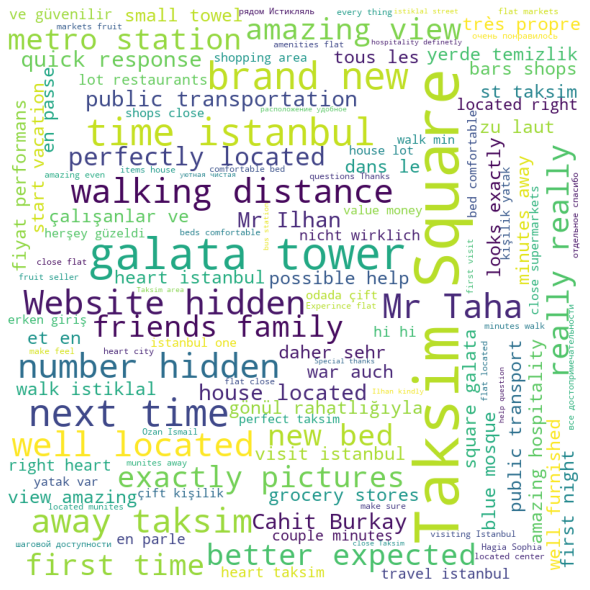

In [74]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
comment_words = ''
stopwords = set(STOPWORDS).union(add_stopwords)
comments = df_grouped_strings.query("neighbourhood_cleansed == 'Beyoglu'")['comments'].to_list()[0][-45000:]

translator = Translator()
comments = translator.translate(comments).text

tokens = comments.split() 

for i in range(len(tokens)): 
  tokens[i] = tokens[i].lower()     
  comment_words += " ".join(tokens)+" "



wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

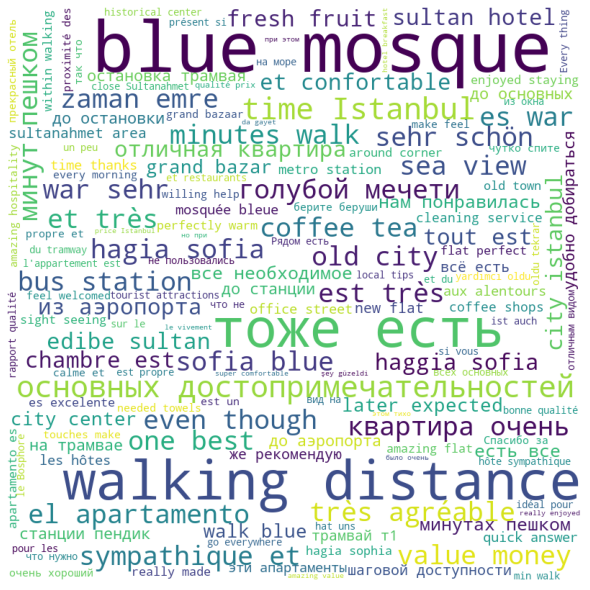

In [75]:
comment_words = ''
stopwords = set(STOPWORDS).union(add_stopwords)
comments = df_grouped_strings.query("neighbourhood_cleansed == 'Fatih'")['comments'].to_list()[0][-45000:]

#translator = Translator()
#comments = translator.translate(comments).text

tokens = comments.split() 

for i in range(len(tokens)): 
  tokens[i] = tokens[i].lower()     
  comment_words += " ".join(tokens)+" "



wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

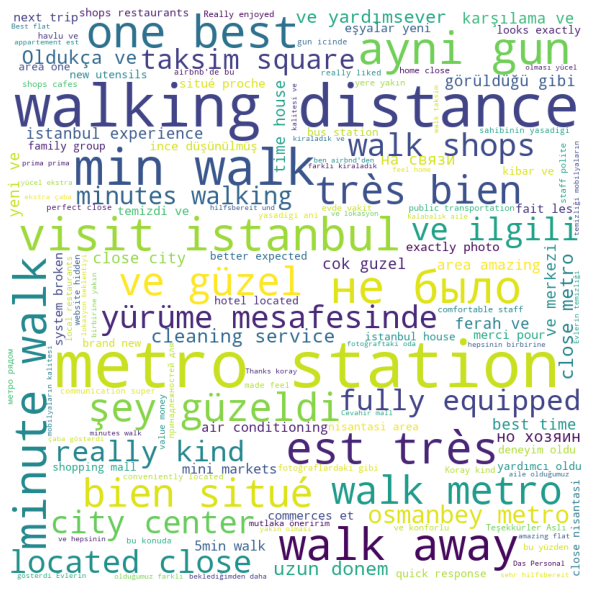

In [76]:
comment_words = ''
stopwords = set(STOPWORDS).union(add_stopwords)
comments = df_grouped_strings.query("neighbourhood_cleansed == 'Sisli'")['comments'].to_list()[0][-45000:]

#translator = Translator()
#comments = translator.translate(comments).text

tokens = comments.split() 

for i in range(len(tokens)): 
  tokens[i] = tokens[i].lower()     
  comment_words += " ".join(tokens)+" "



wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

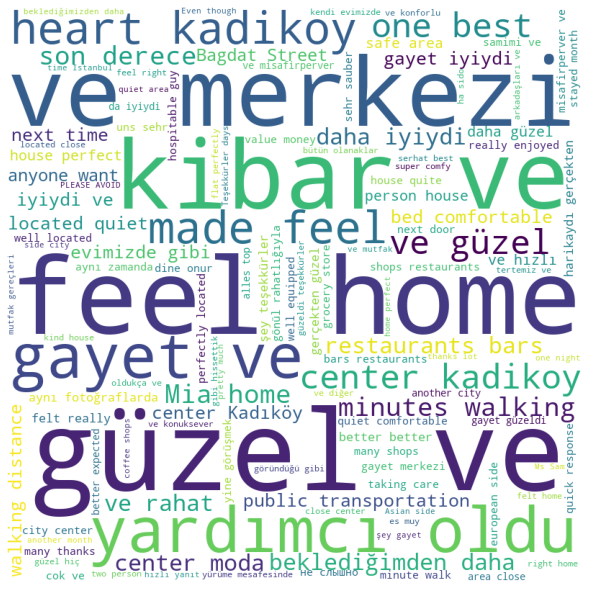

In [77]:
comment_words = ''
stopwords = set(STOPWORDS).union(add_stopwords)
comments = df_grouped_strings.query("neighbourhood_cleansed == 'Kadikoy'")['comments'].to_list()[0][-45000:]

#translator = Translator()
#comments = translator.translate(comments).text

tokens = comments.split() 

for i in range(len(tokens)): 
  tokens[i] = tokens[i].lower()     
  comment_words += " ".join(tokens)+" "



wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

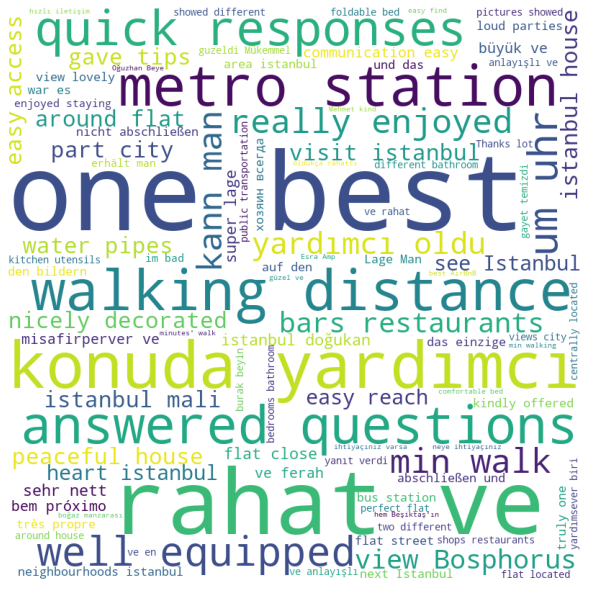

In [78]:
comment_words = ''
stopwords = set(STOPWORDS).union(add_stopwords)
comments = df_grouped_strings.query("neighbourhood_cleansed == 'Besiktas'")['comments'].to_list()[0][-45000:]

#translator = Translator()
#comments = translator.translate(comments).text

tokens = comments.split() 

for i in range(len(tokens)): 
  tokens[i] = tokens[i].lower()     
  comment_words += " ".join(tokens)+" "



wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

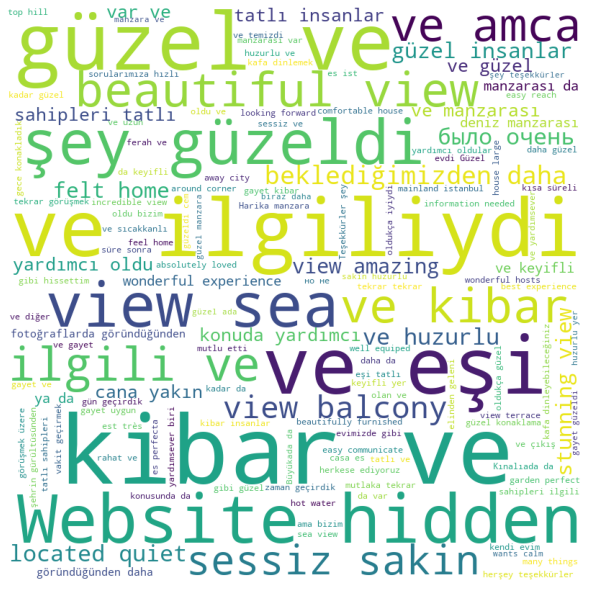

In [79]:
comment_words = ''
stopwords = set(STOPWORDS).union(add_stopwords)
comments = df_grouped_strings.query("neighbourhood_cleansed == 'Adalar'")['comments'].to_list()[0][-45000:]

#translator = Translator()
#comments = translator.translate(comments).text

tokens = comments.split() 

for i in range(len(tokens)): 
  tokens[i] = tokens[i].lower()     
  comment_words += " ".join(tokens)+" "



wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

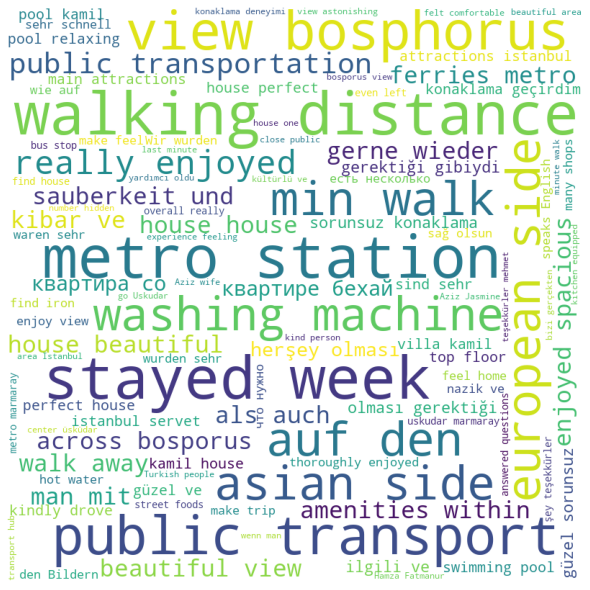

In [80]:
comment_words = ''
stopwords = set(STOPWORDS).union(add_stopwords)
comments = df_grouped_strings.query("neighbourhood_cleansed == 'Uskudar'")['comments'].to_list()[0][-45000:]

#translator = Translator()
#comments = translator.translate(comments).text

tokens = comments.split() 

for i in range(len(tokens)): 
  tokens[i] = tokens[i].lower()     
  comment_words += " ".join(tokens)+" "



wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [86]:
comments = df_grouped_strings.query("neighbourhood_cleansed == 'Beyoglu'")['comments'].to_list()[0][-4000:]
comment_words_beyoglu = []
tokens = comments.split() 

for i in range(len(tokens)): 
  tokens[i] = tokens[i].lower()     
  comment_words_beyoglu += tokens


In [91]:
from wordcloud import (WordCloud, get_single_color_func)
import matplotlib.pyplot as plt


class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)


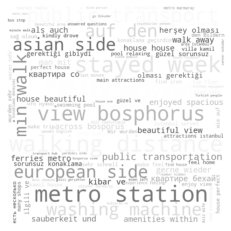

In [94]:

stopwords = set(STOPWORDS).union(add_stopwords)
text = ''






comments = df_grouped_strings.query("neighbourhood_cleansed == 'Beyoglu'")['comments'].to_list()[0][-4000:]
text += comments 
comment_words_beyoglu = []
tokens = comments.split() 

for i in range(len(tokens)): 
  tokens[i] = tokens[i].lower()     
  comment_words_beyoglu += tokens



comments = df_grouped_strings.query("neighbourhood_cleansed == 'Fatih'")['comments'].to_list()[0][-4000:]
text += comments
comment_words_fatih = []
tokens = comments.split() 

for i in range(len(tokens)): 
  tokens[i] = tokens[i].lower()     
  comment_words_fatih += tokens





color_to_words = {
    # words below will be colored with a green single color function
    '#00ff00': comment_words_beyoglu,
    # will be colored with a red single color function
    'red': comment_words_fatih
}




wc = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)

# Since the text is small collocations are turned off and text is lower-cased
#wc = WordCloud(collocations=False).generate(text.lower())


# Words that are not in any of the color_to_words values
# will be colored with a grey single color function
default_color = 'grey'

# Create a color function with single tone
# grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)

# Create a color function with multiple tones
grouped_color_func = GroupedColorFunc(color_to_words, default_color)

# Apply our color function
wc.recolor(color_func=grouped_color_func)

# Plot
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()














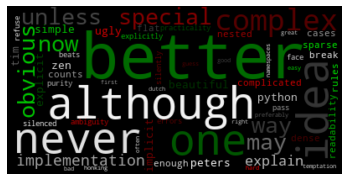

In [81]:
from wordcloud import (WordCloud, get_single_color_func)
import matplotlib.pyplot as plt


class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)


text = """The Zen of Python, by Tim Peters
Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!"""

# Since the text is small collocations are turned off and text is lower-cased
wc = WordCloud(collocations=False).generate(text.lower())

color_to_words = {
    # words below will be colored with a green single color function
    '#00ff00': ['beautiful', 'explicit', 'simple', 'sparse',
                'readability', 'rules', 'practicality',
                'explicitly', 'one', 'now', 'easy', 'obvious', 'better'],
    # will be colored with a red single color function
    'red': ['ugly', 'implicit', 'complex', 'complicated', 'nested',
            'dense', 'special', 'errors', 'silently', 'ambiguity',
            'guess', 'hard']
}

# Words that are not in any of the color_to_words values
# will be colored with a grey single color function
default_color = 'grey'

# Create a color function with single tone
# grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)

# Create a color function with multiple tones
grouped_color_func = GroupedColorFunc(color_to_words, default_color)

# Apply our color function
wc.recolor(color_func=grouped_color_func)

# Plot
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()